# ETF Top Performer Analyzer - POC

In [85]:
# Import Modules
import pandas as pd
import os
import json
import requests
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import sqlalchemy as sql
import ETFHistoryDownload as hist
from datetime import date
import logging
from dateutil.relativedelta import relativedelta
import numpy as np

## STEP1. IMPORT ETF AND CONSTITUENTS (CSV FILES) AND INSERT INTO SQL Tables

In [86]:
#CSV Data Path
etf_list_path = Path('./Resources/etf_list.csv')
etf_constituents_path = Path('./Resources/etf_holdings.csv')
etf_benchmark_path = Path('./Resources/etf_benchmark_list.csv')

In [87]:
#1.Load ETF List from CSV
etf_list_df = pd.read_csv(etf_list_path,index_col='etf', parse_dates=True, infer_datetime_format=True)
etf_list_df

,category,type
etf,,
RYT,Sector,Technology
XSW,Sector,Technology
XLK,Sector,Technology
USRT,Sector,Real Estate
XLRE,Sector,Real Estate
RWR,Sector,Real Estate
BBUS,Purpose,Large_blend
JMOM,Purpose,Large_growth
SPMD,Purpose,Mid_blend


In [88]:
#2.Load ETF Constituents from CSV
etf_constituents_df = pd.read_csv(etf_constituents_path, parse_dates=True, infer_datetime_format=True)
etf_constituents_df

,etf,symbol,name,pct_holding
0,RYT,ENPH,Enphase Energy Inc,0.0192
1,RYT,ANET,Arista Networks Inc,0.0153
2,RYT,CRM,Salesforce.com Inc,0.0153
3,RYT,XLNX,Xilinx Inc,0.0152
4,RYT,PAYC,Paycom Software Inc,0.0151
...,...,...,...,...
1073,XLK,CTXS,Citrix Systems Inc,0.0011
1074,XLK,JNPR,Juniper Networks,0.0009
1075,XLK,DXC,Dxc Technology Company,0.0007
1076,XLK,WU,Western Union Company,0.0007


In [89]:
#2.Load ETF Constituents from CSV
etf_benchmark_df = pd.read_csv(etf_benchmark_path,index_col='etf', parse_dates=True, infer_datetime_format=True)
etf_benchmark_df

,category,type
etf,,
SPY,Benchmark,SP500
QQQ,Benchmark,Nasdaq100


In [90]:
combined = [etf_list_df, etf_benchmark_df]
etf_targetbenchmark_df = pd.concat(combined)
etf_targetbenchmark_df 


,category,type
etf,,
RYT,Sector,Technology
XSW,Sector,Technology
XLK,Sector,Technology
USRT,Sector,Real Estate
XLRE,Sector,Real Estate
RWR,Sector,Real Estate
BBUS,Purpose,Large_blend
JMOM,Purpose,Large_growth
SPMD,Purpose,Mid_blend


In [ ]:
# Create DB
# Database connection string
eft_data_connection_string = 'sqlite:///./Resources/etf.db'
# Database engine
etf_data_engine = sql.create_engine(eft_data_connection_string, echo=True)
# Create two tables from the dataframe
etf_list_df.to_sql('ETF_LIST', etf_data_engine, index_label='etf', if_exists='replace')
etf_constituents_df.to_sql('ETF_CONSTITUENTS', etf_data_engine, index=False, if_exists='replace')

In [92]:
# Select all symbols and names from the Finance sector
sql_query = """
SELECT distinct symbol as name
FROM ETF_CONSTITUENTS
UNION
SELECT distinct etf
FROM ETF_LIST
"""

In [93]:
etf_symbols = pd.read_sql_query(sql_query, eft_data_connection_string)
etf_symbols

,name
0,A
1,AAON
2,AAPL
3,AAT
4,ABBV
...,...
630,ZIXI
631,ZM
632,ZS
633,ZTS


In [94]:
#DEBUG: If need to add more tickers, then add here
etf_symbols = pd.DataFrame(['QQQ','SPY','GLD'],columns = ["name"]) 
etf_symbols

,name
0,QQQ
1,SPY
2,GLD


# STEP2. Download historical Data into SQL DB

In [95]:
#Tweak - Due to API limitation - only download new names by cossing check with existing data

sql_query = """
SELECT distinct symbol as name
FROM STOCK_HISTORY
"""
etf_symbols_exist = pd.read_sql_query(sql_query, eft_data_connection_string)

remaining_list = pd.merge(etf_symbols, etf_symbols_exist, how='outer', indicator=True)
remaining_list = remaining_list.loc[remaining_list._merge == 'left_only', ['name']]

# If need to reset the table (Please don't activate - will take long time to re-download)
#hist.drop_table('STOCK_HISTORY')
if len(remaining_list) > 0:
    day_t0 = date.today()
    hist.download_EFT_holdings(remaining_list, day_t0)


## STEP3. Analyze Stock Performance
Analyze the historical data and store the data with index: symbol

Owner: Albert
Symbol | Total Return | Sharpe Ration | PER  | Corelation |..... * 660 symbols
moving average
Return
Sharpe Ratio
P/E ratio

In [96]:
#hist.drop_table('STOCK_HISTORY')
day_t = date.today()
historical_px_matrix = hist.get_price_history_by_period(day_t)
historical_px_matrix 

period,D0,D7_W1,M1,M3,M6,Y0_YTD,Y1,Y2,Y3
symbol,,,,,,,,,
A,159.81,158.18,150.01,156.52,131.88,118.66,110.2000,76.85,64.50
AAON,76.71,72.63,67.91,70.23,66.04,64.70,65.5700,50.24,42.95
AAPL,150.83,151.49,142.80,145.61,126.86,129.41,115.9700,262.20,194.20
AAT,39.62,38.85,39.01,37.69,34.95,27.41,26.7800,46.91,39.23
ABBV,115.60,117.57,110.34,114.81,116.19,105.41,98.8600,85.67,89.68
...,...,...,...,...,...,...,...,...,...
ZIXI,8.50,8.51,7.39,7.14,6.64,8.36,6.6700,7.11,6.62
ZM,258.40,285.58,253.86,372.36,288.49,359.78,376.2550,68.38,NaN
ZS,352.63,327.66,267.55,240.41,165.77,196.21,127.7862,44.03,39.34


In [97]:
#1. download historical data 1 ~ 2 symbolsCorrelations...
#2. Build Calculation Lib to caclculate TR, SR, PER, CORR, ....
#3. Create the matrix with result
# Symbol | Moving average | Total Return | Sharpe Ratio | PER  | Corelation |..... * 660 symbols
#4. Store back to database table - "PERFORMANCE_MATRIX"

def stock_analzer(etf_symbol):
    alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    return 

In [98]:
preformance_matrix = hist.get_performance_by_period((day_t), True)


In [99]:
sql_query = f"""
SELECT distinct date, count(date) FROM STOCK_HISTORY group by date
"""

available_data_dates = pd.read_sql_query(sql_query, eft_data_connection_string)
market_dates = hist.get_market_datas_by_period(day_t)

dates_list = pd.merge(available_data_dates, market_dates, how='outer', indicator=True)
dates_list= dates_list.loc[dates_list._merge == 'both', ['date', 'count(date)', 'period']]
#dates_list
dates_list 



,date,count(date),period
2,2018-11-12,638,Y3
5,2019-11-11,638,Y2
9,2020-11-10,638,Y1
45,2021-01-04,638,Y0_YTD
132,2021-05-10,638,M6
196,2021-08-10,638,M3
239,2021-10-11,638,M1
256,2021-11-03,638,D7_W1
260,2021-11-09,638,D0


In [100]:
day_t = date.today()
historical_px_matrix = hist.get_price_history_by_period(day_t)
historical_px_matrix

period,D0,D7_W1,M1,M3,M6,Y0_YTD,Y1,Y2,Y3
symbol,,,,,,,,,
A,159.81,158.18,150.01,156.52,131.88,118.66,110.2000,76.85,64.50
AAON,76.71,72.63,67.91,70.23,66.04,64.70,65.5700,50.24,42.95
AAPL,150.83,151.49,142.80,145.61,126.86,129.41,115.9700,262.20,194.20
AAT,39.62,38.85,39.01,37.69,34.95,27.41,26.7800,46.91,39.23
ABBV,115.60,117.57,110.34,114.81,116.19,105.41,98.8600,85.67,89.68
...,...,...,...,...,...,...,...,...,...
ZIXI,8.50,8.51,7.39,7.14,6.64,8.36,6.6700,7.11,6.62
ZM,258.40,285.58,253.86,372.36,288.49,359.78,376.2550,68.38,NaN
ZS,352.63,327.66,267.55,240.41,165.77,196.21,127.7862,44.03,39.34


In [101]:
#1. Now Set Start Acquision Date (Y1) as 2020-11-10 and acquire $10000 for each to compare return 
day_t = date.today()
x_start_date = '2020-11-10'
x_end_date = '2021-05-10'
y_end_date = '2021-11-09'

historical_px_matrix = hist.get_price_history_by_period(day_t)
historical_px_matrix['Start Date'] = '2020-11-10'
historical_px_matrix['Start Cost'] = historical_px_matrix['Y1']
historical_px_matrix['X_End Date'] = '2021-05-10'
historical_px_matrix['X_End Close'] = historical_px_matrix['M6']
historical_px_matrix['X_Return'] = historical_px_matrix['X_End Close'] / historical_px_matrix['Start Cost'] - 1  #pct_change
historical_px_matrix['Y_End Date'] = '2021-11-09'
historical_px_matrix['Y_End Close'] = historical_px_matrix['D0']
historical_px_matrix['Y_Return'] = historical_px_matrix['Y_End Close'] / historical_px_matrix['Start Cost'] - 1 #pct_change
#historical_px_matrix['Unit Cost'] = historical_px_matrix['Y1']
#historical_px_matrix['Quantity_rnd'] = round(10000 / historical_px_matrix['Unit Cost'],0) # ignore rounding to make 100000
#historical_px_matrix['Quantity'] = 10000 / historical_px_matrix['Unit Cost'] # ignore rounding to make 100000
#historical_px_matrix['Cost Basis'] = historical_px_matrix['Quantity'] * historical_px_matrix['Unit Cost']
#historical_px_matrix['Return_M6_2021-05-10'] = historical_px_matrix['M6'] / historical_px_matrix['Unit Cost'] - 1
#historical_px_matrix['Return_D0_2021-11-09'] = historical_px_matrix['D0'] / historical_px_matrix['Unit Cost'] - 1
#historical_px_matrix


In [102]:
etf_targetbenchmark_df 
etf_targetbenchmark_df["symbol"] = etf_targetbenchmark_df.index
etf_targetbenchmark_df["grp"] = etf_targetbenchmark_df["type"].str[:3]
etf_targetbenchmark_df["grp"] = etf_targetbenchmark_df["grp"].str.upper()
performance_benchmark = pd.merge(etf_targetbenchmark_df, historical_px_matrix, on = ["symbol"])   
performance_benchmark

,category,type,symbol,grp,D0,D7_W1,M1,M3,M6,Y0_YTD,...,Y2,Y3,Start Date,Start Cost,X_End Date,X_End Close,X_Return,Y_End Date,Y_End Close,Y_Return
0,Sector,Technology,RYT,TEC,317.8300,311.180,288.37,298.7300,270.32,250.34,...,189.07,151.228,2020-11-10,226.61,2021-05-10,270.32,0.192886,2021-11-09,317.8300,0.402542
1,Sector,Technology,XSW,TEC,186.8500,182.910,171.61,172.0100,153.47,151.01,...,97.35,79.120,2020-11-10,127.36,2021-05-10,153.47,0.205009,2021-11-09,186.8500,0.467101
2,Sector,Technology,XLK,TEC,167.2900,163.700,151.10,153.2500,135.52,127.90,...,86.17,67.410,2020-11-10,118.46,2021-05-10,135.52,0.144015,2021-11-09,167.2900,0.412207
3,Sector,Real Estate,USRT,REA,64.1900,64.470,59.64,60.3900,56.36,46.71,...,54.48,48.400,2020-11-10,47.59,2021-05-10,56.36,0.184282,2021-11-09,64.1900,0.348813
4,Sector,Real Estate,XLRE,REA,48.3900,48.660,44.69,46.0300,42.53,35.38,...,37.85,33.185,2020-11-10,36.78,2021-05-10,42.53,0.156335,2021-11-09,48.3900,0.315661
5,Sector,Real Estate,RWR,REA,116.3100,116.450,107.74,109.1400,101.78,83.55,...,102.49,93.640,2020-11-10,85.87,2021-05-10,101.78,0.185280,2021-11-09,116.3100,0.354489
6,Purpose,Large_blend,BBUS,LAR,85.6600,85.160,79.72,81.3600,76.57,67.90,...,55.57,NaN,2020-11-10,64.56,2021-05-10,76.57,0.186029,2021-11-09,85.6600,0.326828
7,Purpose,Large_growth,JMOM,LAR,48.7900,48.530,44.18,45.2399,40.63,38.38,...,29.09,NaN,2020-11-10,35.73,2021-05-10,40.63,0.137140,2021-11-09,48.7900,0.365519
8,Purpose,Mid_blend,SPMD,MID,50.8100,50.540,46.79,47.6800,47.99,39.77,...,35.07,33.020,2020-11-10,37.02,2021-05-10,47.99,0.296326,2021-11-09,50.8100,0.372501
9,Purpose,Mid_growth,MDYG,MID,83.6695,83.350,76.02,78.1900,76.84,68.27,...,54.94,50.590,2020-11-10,63.59,2021-05-10,76.84,0.208366,2021-11-09,83.6695,0.315765


In [103]:
benchmark_x_return_max = performance_benchmark["X_Return"].max()
benchmark_y_return_max = performance_benchmark["Y_Return"].max()
print(f"Benchmark_max_return_x: {benchmark_x_return_max: .2f}%") 
print(f"Benchmark_max_return_y: {benchmark_y_return_max: .2f}%") 


Benchmark_max_return_x:  0.35%
Benchmark_max_return_y:  0.47%


In [104]:
#etf_list_df["etf"] = etf_list_df.index
etf_list_df["grp"] = etf_list_df["type"].str[:3]
etf_list_df["grp"] = etf_list_df["grp"].str.upper()
#etf_list_df
#etf_constituents_df

etf_holings_matrix_df = pd.merge(etf_constituents_df, etf_list_df, how = "inner", on = ["etf"])
etf_exposure_w_cnt = etf_holings_matrix_df.pivot_table(index = 'symbol', columns = 'grp', values = 'pct_holding', aggfunc=pd.Series.nunique)
#table = table.replace(np.nan, 0, inplace=True)
etf_exposure_w_cnt = etf_exposure_w_cnt.fillna(0)
performance_symbols = pd.merge(etf_exposure_w_cnt, historical_px_matrix, on = ["symbol"])
performance_symbols 
picked_symbols = performance_symbols[(performance_symbols['X_Return'] > benchmark_x_return_max ) & (performance_symbols['Y_Return'] > benchmark_y_return_max )]
picked_symbols = picked_symbols.sort_values(['X_Return', 'Y_Return'], ascending =[0, 0])
picked_symbols

,LAR,MID,REA,SMA,TEC,D0,D7_W1,M1,M3,M6,...,Y2,Y3,Start Date,Start Cost,X_End Date,X_End Close,X_Return,Y_End Date,Y_End Close,Y_Return
symbol,,,,,,,,,,,,,,,,,,,,,
GME,0.0,1.0,0.0,0.0,0.0,206.5800,218.59,178.2500,159.0500,143.0100,...,6.0150,13.8900,2020-11-10,11.110,2021-05-10,143.0100,11.872187,2021-11-09,206.5800,17.594059
MARA,0.0,0.0,0.0,0.0,1.0,76.0844,64.71,42.9506,35.6900,27.8512,...,1.2400,0.7025,2020-11-10,2.200,2021-05-10,27.8512,11.659636,2021-11-09,76.0844,33.583818
SM,0.0,0.0,0.0,1.0,0.0,37.4100,35.13,30.6400,18.7500,16.7900,...,9.7300,21.5000,2020-11-10,2.270,2021-05-10,16.7900,6.396476,2021-11-09,37.4100,15.480176
MTDR,0.0,0.0,0.0,2.0,0.0,45.3900,41.94,42.7500,29.3500,28.0100,...,14.7900,24.7900,2020-11-10,8.490,2021-05-10,28.0100,2.299176,2021-11-09,45.3900,4.346290
MSTR,0.0,0.0,0.0,0.0,1.0,859.0000,810.76,732.4700,748.8402,569.3700,...,155.9300,126.5400,2020-11-10,186.150,2021-05-10,569.3700,2.058662,2021-11-09,859.0000,3.614558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GPI,0.0,0.0,0.0,1.0,0.0,202.5000,198.51,186.8900,171.7700,166.7500,...,99.0200,57.3400,2020-11-10,122.970,2021-05-10,166.7500,0.356022,2021-11-09,202.5000,0.646743
TGT,2.0,0.0,0.0,0.0,0.0,255.1700,260.47,228.7200,264.0100,213.9300,...,110.4526,85.4600,2020-11-10,158.010,2021-05-10,213.9300,0.353902,2021-11-09,255.1700,0.614898
FLOW,0.0,0.0,0.0,1.0,0.0,79.5000,77.44,71.9700,79.8000,70.5900,...,45.7000,36.8000,2020-11-10,52.140,2021-05-10,70.5900,0.353855,2021-11-09,79.5000,0.524741


In [105]:
# Pull Historical data based on selected names > add to performance analysis

def get_return_matrix(p_portfolio_df, p_start_date, p_end_date, p_name, p_daily):
    names = hist.get_where_condition(p_portfolio_df, 'symbol')
    names
    sql_query = f"""
    SELECT date, symbol, close FROM STOCK_HISTORY WHERE (date > '{p_start_date}' and date <= '{p_end_date}') and symbol in ({names})
    """
    portfolio_df = pd.read_sql_query(sql_query, eft_data_connection_string)
    stock_hist_matrix = portfolio_df.pivot('date','symbol',values = 'close')  
    stock_hist_matrix = stock_hist_matrix.pct_change().dropna()
    stock_hist_matrix['daily_return'] = stock_hist_matrix.mean(numeric_only=True, axis=1)
    if p_daily == True:
        stock_hist_matrix[p_name] = stock_hist_matrix['daily_return']
    else:
        stock_hist_matrix[p_name] = (1+ stock_hist_matrix['daily_return']).cumprod()
    return(stock_hist_matrix[[p_name]])

    #return(stock_hist_matrix[["daily_return","cum_return"]])

def back_calc_price100_from_daily_return(p_dataframe, p_name):
    start_value = 100
    for index, row in p_dataframe.iterrows():
        row[p_name] = (row[p_name] + 1) * start_value
        start_value = row[p_name]
    return p_dataframe

x_start_date = '2020-11-10'
x_end_date = '2021-05-10'
y_end_date = '2021-11-09'

#1. Get_returns of picked_symbols
picked_symbols['symbol'] = picked_symbols.index
etf_list =  performance_benchmark[performance_benchmark['symbol'] != 'SPY']
etf_list =  etf_list[etf_list['symbol'] != 'QQQ']
sp500_list = performance_benchmark.loc[performance_benchmark['symbol'] == 'SPY']
na100_list = performance_benchmark.loc[performance_benchmark['symbol'] == 'QQQ']

our_return = get_return_matrix(picked_symbols, x_start_date, y_end_date, 'OURS', False)
etf_return = get_return_matrix(etf_list, x_start_date, y_end_date, 'ETFs', False)
sp500_return = get_return_matrix(sp500_list, x_start_date, y_end_date, 'SPY', False)
na100_return = get_return_matrix(na100_list, x_start_date, y_end_date, 'QQQ', False)
cum_return_matrix = pd.DataFrame.merge(our_return, etf_return, on = 'date')
cum_return_matrix = pd.DataFrame.merge(cum_return_matrix, sp500_return, on = 'date')
cum_return_matrix = pd.DataFrame.merge(cum_return_matrix, na100_return, on = 'date')
cum_return_matrix

symbol,OURS,ETFs,SPY,QQQ
date,,,,
2020-11-12,0.984985,0.986005,0.990634,0.995101
2020-11-13,1.015338,1.003717,1.001991,1.005658
2020-11-16,1.039624,1.017090,1.016292,1.011075
2020-11-17,1.055623,1.021452,1.011273,1.007866
2020-11-18,1.047810,1.007633,0.999075,1.000794
...,...,...,...,...
2021-11-03,2.472567,1.365058,1.303152,1.356731
2021-11-04,2.475533,1.365345,1.309125,1.373999
2021-11-05,2.498294,1.374517,1.313695,1.375138


In [106]:
#def get_price_history(p_portfolio_df, p_start_date, p_end_date):
#    names = hist.get_where_condition(p_portfolio_df, 'symbol')
#    names
#    sql_query = f"""
#    SELECT date, symbol, close FROM STOCK_HISTORY WHERE (date > '{p_start_date}' and date <= '{p_end_date}') and symbol in ({names})
#    """
#    portfolio_df = pd.read_sql_query(sql_query, eft_data_connection_string)
#    stock_hist_matrix = portfolio_df.pivot('date','symbol',values = 'close')
#    stock_hist_matrix['avg_price'] = stock_hist_matrix.mean(numeric_only=True, axis=1)
#    stock_hist_matrix['daily_return'] = stock_hist_matrix['avg_price'].pct_change().dropna()
#    return stock_hist_matrix


        
    
sp500_return = get_return_matrix(sp500_list, x_start_date, y_end_date, 'SPY', True)    
    
    
import alpaca_trade_api as tradeapi
#by calling the load_dotenv function
load_dotenv()
# Set Alpaca API key and secret
tickers = ['QQQ']
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")
timeframe = "1D"
today = pd.Timestamp("2021-10-23", tz="America/New_York").isoformat()

# Set both the start and end date at the date of your prior weekday 
start = pd.Timestamp("2018-10-22", tz="America/New_York").isoformat()
end = pd.Timestamp("2021-10-22", tz="America/New_York").isoformat()

limit_rows = 1000
df_portfolio_threeyears = alpaca_api.get_barset(
    tickers,
    timeframe,
    start = start,
    end = end,
    limit = limit_rows
).df
sp500_price = back_calc_price100_from_daily_return(sp500_return, 'SPY')
#df_portfolio_threeyears = df_portfolio_threeyears.drop(columns = ['open','low','high','volume'], level=1)
#df_portfolio_threeyears['date']= pd.to_datetime(df_portfolio_threeyears.index).date
#sp500_price.columns = pd.MultiIndex.from_product([sp500_price.columns, ['close']])
#sp500_price
#df_portfolio_threeyears2 = pd.merge(df_portfolio_threeyears, sp500_price, on = 'date') 
df_portfolio_threeyears
#sp500_return 

#sp500_price = back_calc_price100_from_daily_return(sp500_return, 'SPY')
#sp500_price


QQQ                                       
                             open      high       low   close     volume
time                                                                    
2018-10-22 00:00:00-04:00  174.05  175.2485  172.5900  173.92   43329623
2018-10-23 00:00:00-04:00  170.80  174.1300  168.8200  173.40   66393323
2018-10-24 00:00:00-04:00  173.12  173.3600  165.0400  165.34   83587767
2018-10-25 00:00:00-04:00  167.99  172.0800  167.1600  170.96   63322733
2018-10-26 00:00:00-04:00  165.25  169.9600  164.2300  166.79  109195771
...                           ...       ...       ...     ...        ...
2021-10-18 00:00:00-04:00  367.60  372.8700  366.9900  372.65   28085085
2021-10-19 00:00:00-04:00  373.74  375.5200  372.6974  375.44   25228935
2021-10-20 00:00:00-04:00  375.94  376.5650  373.4600  374.98   27504995
2021-10-21 00:00:00-04:00  374.14  377.4700  373.8500  377.27   20890389
2021-10-22 00:00:00-04:00  375.98  376.9700  372.3850  374.03   32854830

[757 rows x 5 columns]

In [107]:
our_return = get_return_matrix(picked_symbols, x_start_date, y_end_date, 'OURS', True)
our_return_org = our_return.copy()
start_value = 100
for index, row in our_return.iterrows():
    row['OURS'] = (row['OURS'] + 1) * start_value
    start_value = row['OURS']
    
our_return.pct_change().dropna() 
#our_return.loc[1, 'OURS'] = 100
#for i in range(2, len(our_return)):
#    our_return.loc[i, 'OURS'] = (our_return.loc[i, 'OURS'] + 1) * our_return.loc[i-1, 'OURS']

#our_return 
#our_return['px'] = 100 / our_return['OURS']
#our_return['daily_return'] = our_return['px'].pct_change().dropna()
#our_return


#sp500_return = get_return_matrix(sp500_list, x_start_date, y_end_date, 'SPY', True)
#sp500_return

symbol,OURS
date,
2020-11-13,0.030816
2020-11-16,0.023919
2020-11-17,0.015389
2020-11-18,-0.007401
2020-11-19,0.015235
...,...
2021-11-03,0.013303
2021-11-04,0.001199
2021-11-05,0.009194


In [108]:
our_return_org 
#our_return

#get_price_history(sp500_list, x_start_date, y_end_date)

symbol,OURS
date,
2020-11-12,-0.015015
2020-11-13,0.030816
2020-11-16,0.023919
2020-11-17,0.015389
2020-11-18,-0.007401
...,...
2021-11-03,0.013303
2021-11-04,0.001199
2021-11-05,0.009194


<AxesSubplot:title={'center':'Cumulative Returns of OURS vs. Benchmarks'}, xlabel='date'>

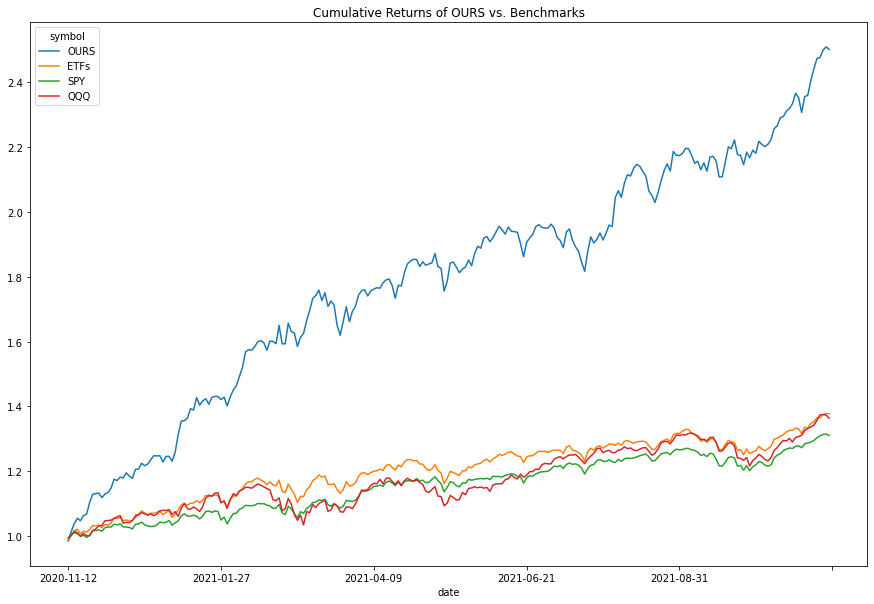

In [109]:
cum_return_matrix.plot(figsize=(15,10), title="Cumulative Returns of OURS vs. Benchmarks")

<AxesSubplot:title={'center':'Volatility Analysis of OURS vs. Benchmarks'}>

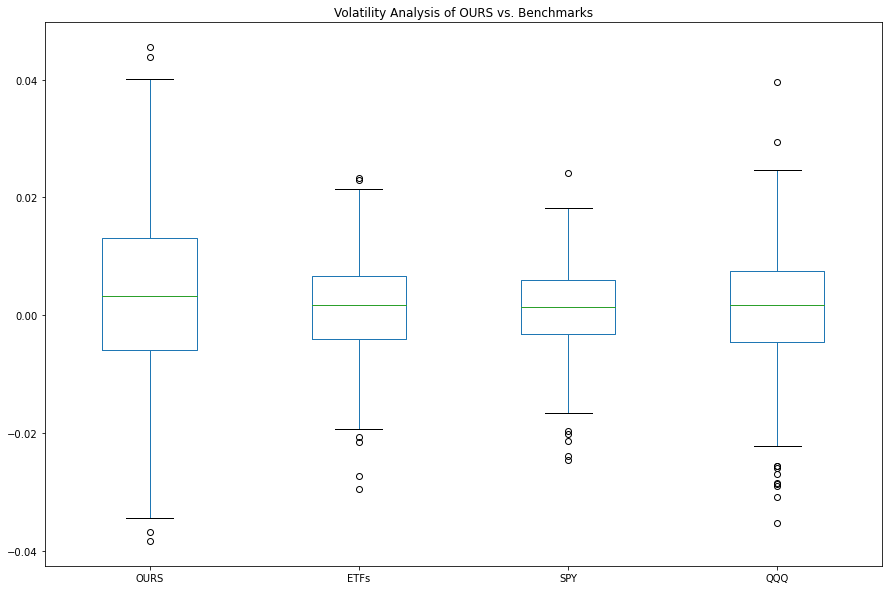

In [110]:
our_return = get_return_matrix(picked_symbols, x_start_date, y_end_date, 'OURS', True)
etf_return = get_return_matrix(etf_list, x_start_date, y_end_date, 'ETFs', True)
sp500_return = get_return_matrix(sp500_list, x_start_date, y_end_date, 'SPY', True)
na100_return = get_return_matrix(na100_list, x_start_date, y_end_date, 'QQQ', True)
daily_return_matrix = pd.DataFrame.merge(our_return, etf_return, on = 'date')
daily_return_matrix = pd.DataFrame.merge(daily_return_matrix, sp500_return, on = 'date')
daily_return_matrix = pd.DataFrame.merge(daily_return_matrix, na100_return, on = 'date')


daily_return_matrix.plot(kind='box',figsize=(15,10),title='Volatility Analysis of OURS vs. Benchmarks')

In [84]:
daily_return_matrix
def back_calc_price100_from_daily_return(p_dataframe, p_name):
    start_value = 100
    for index, row in p_dataframe.iterrows():
        row[p_name] = (row[p_name] + 1) * start_value
        start_value = row[p_name]
    return p_dataframe

#df = back_calc_price100_from_daily_return(daily_return_matrix, "ETFs")
#daily_return_matrix

In [68]:
# Review the annual standard deviations smallest to largest
daily_return_matrix_std = daily_return_matrix.std()
daily_return_matrix_std = daily_return_matrix_std.sort_values()
daily_return_matrix_std 

symbol
SPY     0.007710
ETFs    0.008934
QQQ     0.010663
OURS    0.014398
dtype: float64

<AxesSubplot:title={'center':'Rolling 30-Day Standard Deviation of Daily Returns - 4 OURS vs. Benchmarks'}, xlabel='date'>

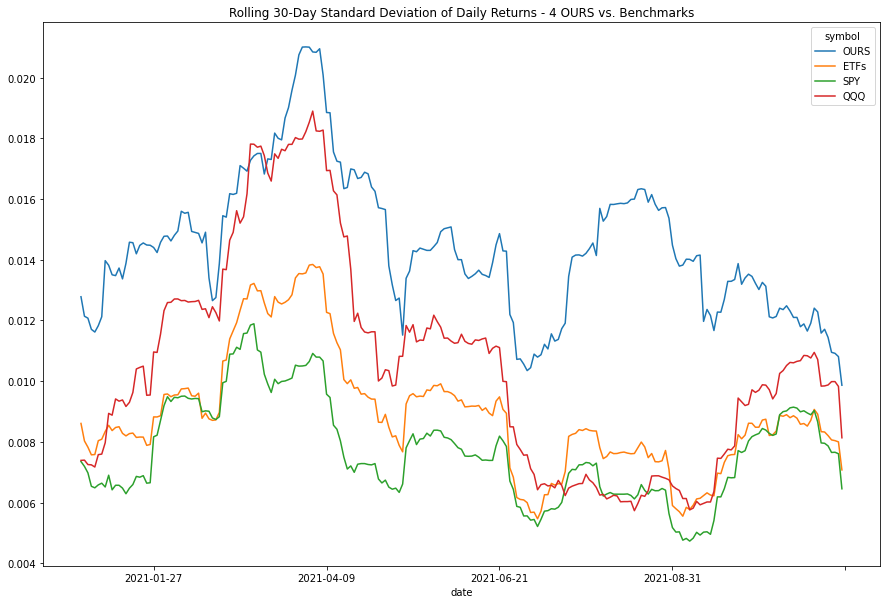

In [69]:
daily_return_matrix.rolling(window=30).std().plot(figsize=(15,10), title='Rolling 30-Day Standard Deviation of Daily Returns - 4 OURS vs. Benchmarks')

In [70]:
# Use 252 as the number of trading days in the year
year_trading_days = 252
# Calculate the annual average return data for the for fund portfolios and the S&P 500
average_annual_return = daily_return_matrix.mean() * year_trading_days

# Review the annual average returns sorted from lowest to highest
average_annual_return.sort_values()
average_annual_return

symbol
OURS    0.951588
ETFs    0.333144
SPY     0.280250
QQQ     0.327240
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios of OURS vs. Benchmarks Daily Return'}, xlabel='symbol'>

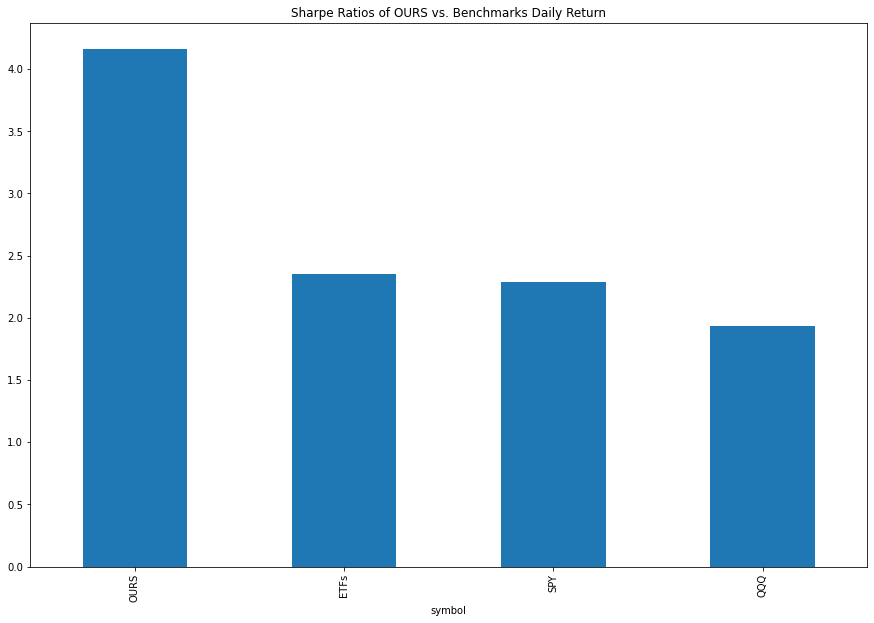

In [71]:
annualized_standard_deviation = daily_return_matrix.std() * (year_trading_days) ** (1 / 2)
sharpe_ratios = average_annual_return / annualized_standard_deviation
sharpe_ratios.sort_values()
sharpe_ratios.plot.bar(figsize=(15,10), title="Sharpe Ratios of OURS vs. Benchmarks Daily Return")

In [72]:
#Calculate the variance of the S&P 500 using a rolling 60-day window.
sp500_variance = daily_return_matrix['SPY'].rolling(window=60).var().dropna()
sp500_variance_df = pd.DataFrame(sp500_variance)
sp500_variance_df = sp500_variance_df.rename(columns={'SPY': 'SPY Var'})
sp500_variance.tail()

matrix_navs_covariance = daily_return_matrix.rolling(window=60).cov(daily_return_matrix['SPY'].rolling(window=60)).dropna()
matrix_navs_beta = matrix_navs_covariance.div(sp500_variance_df['SPY Var'], axis = 0)
matrix_navs_beta.dropna()
matrix_navs_beta.tail()
matrix_navs_beta.mean()

symbol
OURS    1.366094
ETFs    1.059947
SPY     1.000000
QQQ     1.165454
dtype: float64

In [73]:
Performance_summary = pd.DataFrame(daily_return_matrix_std, columns = ['Annualized_std_dev'])
Performance_summary = pd.merge(Performance_summary, pd.DataFrame(average_annual_return, columns = ['Annualized_return']), on = 'symbol')
Performance_summary = pd.merge(Performance_summary, pd.DataFrame(sharpe_ratios, columns = ['Sharpe_ratios']), on = 'symbol')
Performance_summary = pd.merge(Performance_summary, pd.DataFrame(matrix_navs_beta.mean(), columns = ['Beta to SP500']), on = 'symbol')
Performance_summary

,Annualized_std_dev,Annualized_return,Sharpe_ratios,Beta to SP500
symbol,,,,
SPY,0.007710,0.280250,2.289639,1.000000
ETFs,0.008934,0.333144,2.349038,1.059947
QQQ,0.010663,0.327240,1.933236,1.165454
OURS,0.014398,0.951588,4.163328,1.366094


In [74]:
#daily_return_matrix = back_calc_price100_from_daily_return(daily_return_matrix, 'OURS')
daily_return_matrix

symbol,OURS,ETFs,SPY,QQQ
date,,,,
2020-11-12,-0.015015,-0.013995,-0.009366,-0.004899
2020-11-13,0.030816,0.017963,0.011464,0.010610
2020-11-16,0.023919,0.013323,0.014273,0.005386
2020-11-17,0.015389,0.004290,-0.004939,-0.003174
2020-11-18,-0.007401,-0.013529,-0.012062,-0.007018
...,...,...,...,...
2021-11-03,0.013303,0.009053,0.006192,0.010575
2021-11-04,0.001199,0.000210,0.004583,0.012728
2021-11-05,0.009194,0.006717,0.003491,0.000829


In [118]:
#Get Price Changes
def back_calc_price100_from_daily_return(p_dataframe, p_name):
    start_value1 = 100
    start_value2 = 100
    start_value3 = 100
    start_value4 = 100
    
    for index, row in p_dataframe.iterrows():
        row[p_name] = (row[p_name] + 1) * start_value1
        row['ETFs'] = (row['ETFs'] + 1) * start_value2
        row['SPY'] = (row['SPY'] + 1) * start_value3
        row['QQQ'] = (row['QQQ'] + 1) * start_value4
        start_value1 = row[p_name]
        start_value2 = row['ETFs']
        start_value3 = row['SPY']
        start_value4 = row['QQQ']
    return p_dataframe

daily_return_matrix2 = daily_return_matrix.copy()
df = back_calc_price100_from_daily_return(daily_return_matrix2, 'OURS')
df.index = pd.to_datetime(df.index).datetime
df 

AttributeError: 'DatetimeIndex' object has no attribute 'datetime'

In [35]:
sp500_return = get_return_matrix(sp500_list, x_start_date, y_end_date)
sp500_return 

TypeError: get_return_matrix() missing 2 required positional arguments: 'p_name' and 'p_daily'

In [ ]:
etf_return = get_return_matrix(na100_list, x_start_date, y_end_date)
etf_return 


In [36]:
etf_return['cum_return'].plot

KeyError: 'cum_return'

In [ ]:
stock_hist_matrix['cum_return'] = (1+ stock_hist_matrix['daily_return']).cumprod()
stock_hist_matrix

In [ ]:
#TO-DO: Albert - 
# Could you add analysis columns to performance_matrix?
# you can pull history from STOCK_HISTORY table
day_1 = date.today() + relativedelta(days=-1)
year_1 = day_1 + relativedelta(years=-1)

sql_query = f"""
SELECT date, symbol, close FROM STOCK_HISTORY WHERE date > '{year_1}'
"""

stock_history = pd.read_sql_query(sql_query, eft_data_connection_string)
stock_history


In [ ]:
x_start_date = '2020-11-10'
x_end_date = '2021-05-10'
y_end_date = '2021-11-09'

# 4. Cherry Picking to create our portfolio
pick best based on performance scoring matrix per investment criteria and benchmark EFTs
Owner: Ken Lee

In [ ]:
def Stock_picker(eft_symbol, criteria):
    #stock_picker.py
    #code here
    #return dataframe with pick
    return

In [ ]:
sector_choice = int(input("Enter Sector Choice: (1. Technology 2. RealEstate 3.Both):"))
strategy_choice = int(input("Enter Strategy Preference: (1.LargeCap 2. MidCap 3. SmallCap 4.All Blended):"))
    
sector_technology = 0
sector_realestate = 0
cap_large = 0
cap_mid = 0
cap_small = 0

if sector_choice == 1:
    sector_technology = 1
elif sector_choice == 2:
    sector_realestate = 1
else:
    sector_technology = 1
    sector_realestate = 1


if strategy_choice == 1:
    sector_technology = 1
elif sector_choice == 2:
    sector_realestate = 1
else:
    sector_technology = 1
    sector_realestate = 1

    

In [ ]:
#TO-DO: Minglu Li
#  Could you add monteCarlo simularation on 3 names: SPY, QQQ, GLD?
# GLD is the placeholder of our bespoke portfolio
day_1 = date.today() + relativedelta(days=-1)
year_1 = day_1 + relativedelta(years=-1)

sql_query = f"""
SELECT date, symbol, close FROM STOCK_HISTORY WHERE date > '{year_1}' and symbol in ('SPY','QQQ','GLD')
"""

stock_3ETF = pd.read_sql_query(sql_query, eft_data_connection_string)
stock_3ETF

# 5. Performance Forecast Visualization - Validation
Show our portfolio performance with Chart and Matrix
Run Montecarlo simulation
Compare performance Forecast
Owner: Minglu

In [ ]:
daily_return_matrix
#daily_return_matrix.columns = pd.MultiIndex.from_product([daily_return_matrix.columns, ['close']])
daily_return_matrix






# 6. REPORT
1. Summarize the analysis and results
2. Future improvement and limitation --no Dividend and CF analysis

In [ ]:
def report_visualization():
    # Import the hvPlot library
    import hvplot.pandas
    #code here
    # See 06-Data-Visualization-with-PyViz/
    # Report with charts
    return